In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

In [13]:
original_cpu = RSC_sim.get_original_sequence()
seq_cpu = original_cpu[0]*10

In [14]:
original_gpu = cr.get_original_sequences_gpu()  # list/tuple of cp.ndarray blocks

# Repeat each block along the first axis, then concatenate in order
blocks = [
    cp.tile(original_gpu[0], (10, 1)),  # repeat 10 times
]

seq_gpu = cp.concatenate(blocks, axis=0)

In [15]:
temp = [25e-6, 25e-6, 25e-6]
def run_cpu(mols_cpu_num, seq_cpu):
    # Adjust max_workers to your machine; user sample uses 16.
    mols_cpu = RSC_sim.initialize_thermal(temp, mols_cpu_num)
    RSC_sim.apply_raman_sequence(mols_cpu, seq_cpu, max_workers=16)

def run_gpu(mols_gpu_num, seq_gpu, res, K_max=30):
    mols_gpu = cr.build_thermal_molecules_gpu(mols_gpu_num, temp)
    cr.raman_cool_with_pumping(mols_gpu, seq_gpu, res, K_max=K_max)
    del mols_gpu

In [16]:
def bench_func_with_cupy_benchmark(fn, *args, n_repeat=5, n_warmup=None, **kwargs):
    """
    Use cupyx.profiler.benchmark to benchmark a callable (CPU or GPU).
    Returns (mean, std) in seconds.
    - For GPU work, uses GPU times (device-synchronized).
    - For CPU-only work, falls back to CPU times.
    """
    if n_warmup is None:
        n_warmup = max(1, n_repeat // 5)

    # Warmup (important for JIT / memory allocation)
    fn(*args, **kwargs)

    res = cupyx.profiler.benchmark(
        fn, args=args, kwargs=kwargs, n_repeat=n_repeat, n_warmup=n_warmup
    )

    # Safely select the correct timing array
    times = None
    if hasattr(res, "gpu_times") and res.gpu_times is not None and len(res.gpu_times) > 0:
        times = np.asarray(res.gpu_times, dtype=float)
    elif hasattr(res, "cpu_times") and res.cpu_times is not None and len(res.cpu_times) > 0:
        times = np.asarray(res.cpu_times, dtype=float)
    elif hasattr(res, "times") and res.times is not None and len(res.times) > 0:
        times = np.asarray(res.times, dtype=float)
    else:
        raise RuntimeError("cupyx.profiler.benchmark did not return valid timing arrays.")

    mean_s = float(times.mean())
    std_s = float(times.std(ddof=1) if times.size > 1 else 0.0)
    return mean_s, std_s

In [17]:
temp = [25e-6, 25e-6, 25e-6]


# Molecule counts (log spaced)
cpu_sizes = np.unique(np.logspace(2, 4, num=9, base=10)).astype(int)   # 1e2 .. 1e4
gpu_sizes = np.unique(np.logspace(2, 5, num=11, base=10)).astype(int)  # 1e2 .. 1e5

cpu_sizes = np.concatenate((np.array([10, 50]), cpu_sizes))
gpu_sizes = np.concatenate((np.array([10, 50]), gpu_sizes))

print(cpu_sizes)
print(gpu_sizes)

[   10    50   100   177   316   562  1000  1778  3162  5623 10000]
[    10     50    100    199    398    794   1584   3162   6309  12589
  25118  50118 100000]


In [18]:
# ---------------- CPU sweep ----------------
cpu_means, cpu_stds = [], []
for n in cpu_sizes:
    mean_s, std_s = bench_func_with_cupy_benchmark(run_cpu, n, seq_cpu, n_repeat=5)
    cpu_means.append(mean_s)
    cpu_stds.append(std_s)
    print(f"CPU n={n}: {mean_s:.4f}s ± {std_s:.4f}s")


Applying pulses to molecules: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


CPU n=10: 5.8434s ± 0.4740s


Applying pulses to molecules: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


CPU n=50: 14.1382s ± 0.5902s


Applying pulses to molecules: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


CPU n=100: 15.3807s ± 1.4701s


Applying pulses to molecules: 100%|██████████| 177/177 [00:12<00:00, 14.54it/s]


CPU n=177: 14.6287s ± 0.4884s


Applying pulses to molecules: 100%|██████████| 316/316 [00:12<00:00, 26.12it/s] 


CPU n=316: 14.3401s ± 0.2562s


Applying pulses to molecules: 100%|██████████| 562/562 [00:13<00:00, 40.53it/s] 


CPU n=562: 17.2162s ± 0.7085s


Applying pulses to molecules: 100%|██████████| 1000/1000 [00:16<00:00, 59.00it/s]


CPU n=1000: 20.9644s ± 1.1478s


Applying pulses to molecules: 100%|██████████| 1778/1778 [00:24<00:00, 71.38it/s] 


CPU n=1778: 28.1348s ± 0.3681s


Applying pulses to molecules: 100%|██████████| 3162/3162 [00:34<00:00, 91.75it/s] 


CPU n=3162: 38.9505s ± 1.0022s


Applying pulses to molecules: 100%|██████████| 5623/5623 [00:52<00:00, 107.08it/s]


CPU n=5623: 62.3105s ± 2.2734s


Applying pulses to molecules: 100%|██████████| 10000/10000 [01:22<00:00, 121.50it/s]


CPU n=10000: 89.7373s ± 0.6322s


In [19]:

gpu_means, gpu_stds = [], []
# ---------------- GPU sweep ----------------
# Memory pool helps avoid OOM and gets consistent timings
mpool = cp.get_default_memory_pool()
for n in gpu_sizes:
    # Pre-synchronize before timing
    cp.cuda.Device().synchronize()

    mean_s, std_s = bench_func_with_cupy_benchmark(run_gpu, n, seq_gpu, res, K_max=30, n_repeat=5)
    gpu_means.append(mean_s)
    gpu_stds.append(std_s)
    print(f"GPU n={n:>6}: mean={mean_s:.4f}s  std={std_s:.4f}s")

    cp.cuda.Device().synchronize()
    mpool.free_all_blocks()


GPU n=    10: mean=0.8201s  std=0.1366s
GPU n=    50: mean=1.9423s  std=0.3313s
GPU n=   100: mean=2.3634s  std=0.3465s
GPU n=   199: mean=3.0932s  std=0.2827s
GPU n=   398: mean=3.4484s  std=0.1816s
GPU n=   794: mean=4.1532s  std=0.2331s
GPU n=  1584: mean=5.6649s  std=0.2127s
GPU n=  3162: mean=6.4195s  std=0.2139s
GPU n=  6309: mean=8.0294s  std=0.1858s
GPU n= 12589: mean=12.8335s  std=0.3998s
GPU n= 25118: mean=21.4563s  std=0.4452s
GPU n= 50118: mean=40.5348s  std=0.5651s
GPU n=100000: mean=80.1135s  std=0.8893s


In [2]:
data = np.load("XY_benchmark.npz")
cpu_sizes = data['cpu_sizes']
cpu_means = data['cpu_means']
cpu_stds = data['cpu_stds']
gpu_sizes = data['gpu_sizes']
gpu_means = data['gpu_means']
gpu_stds = data['gpu_stds']

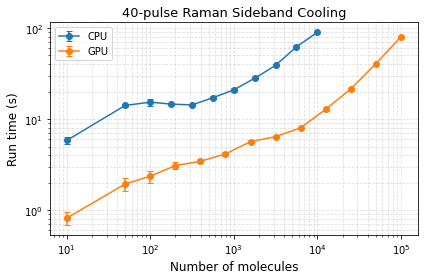

In [4]:
import matplotlib.ticker as ticker
plt.figure()
plt.errorbar(cpu_sizes, 
             cpu_means, 
             yerr=cpu_stds, 
             fmt='o-', capsize=3, label='CPU')
plt.errorbar(gpu_sizes, 
             gpu_means, 
             yerr=gpu_stds, 
             fmt='o-', capsize=3, label='GPU')
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*0.1, numticks=100))
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.xlabel('Number of molecules', fontsize=12)
plt.ylabel('Run time (s)', fontsize=12)
plt.title("40-pulse Raman Sideband Cooling", fontsize=13)

plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
np.savez(
    "XY_benchmark.npz", 
    cpu_sizes=cpu_sizes, 
    cpu_means=cpu_means,
    cpu_stds=cpu_stds,
    gpu_sizes=gpu_sizes,
    gpu_means=gpu_means,
    gpu_stds=gpu_stds)